In [1]:
from pathlib import Path
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt


In [2]:
DATA_DIR = Path("./Dataset/_outputs_train_val_test")
FINAL_DATASET = DATA_DIR / "final_dataset.csv"

df = pd.read_csv(FINAL_DATASET)

# bỏ cột index kiểu "Unnamed: 0" nếu có
drop_cols = [c for c in df.columns if str(c).strip().lower().startswith("unnamed:")]
if drop_cols:
    df = df.drop(columns=drop_cols)

df.columns, df.shape


(Index(['payload', 'label', 'hash', 'source', 'path'], dtype='object'),
 (19359, 5))

In [3]:
def pick_col(df, candidates):
    canon = {str(c).strip().lower(): c for c in df.columns}
    for k in candidates:
        if k in canon:
            return canon[k]
    return None

payload_col = pick_col(df, ["payload", "sentence", "text", "code", "content"])
label_col   = pick_col(df, ["label", "class", "target", "y", "is_xss", "malicious"])

if payload_col is None or label_col is None:
    raise KeyError(f"Không tìm thấy cột payload/label. Columns: {list(df.columns)}")

work = df[[payload_col, label_col]].rename(columns={payload_col:"payload", label_col:"label"}).dropna()
work["payload"] = work["payload"].astype(str)
work["label"] = work["label"].astype(int)

def normalize_text(s: str) -> str:
    s = str(s).lower().replace("\n", " ").replace("\r", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

work["payload"] = work["payload"].map(normalize_text)
work = work[work["payload"].str.len() > 0]
work = work.drop_duplicates(subset=["payload", "label"]).reset_index(drop=True)

work.shape, work["label"].value_counts()


((19357, 2),
 label
 0    12037
 1     7320
 Name: count, dtype: int64)

In [4]:
train_df, test_df = train_test_split(
    work, test_size=0.2, random_state=42, stratify=work["label"]
)

train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

train_df.shape, test_df.shape


((15485, 2), (3872, 2))

In [5]:
vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
X_train = vectorizer.fit_transform(train_df["payload"])
y_train = train_df["label"].values

X_test = vectorizer.transform(test_df["payload"])
y_test = test_df["label"].values

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM (LinearSVC)": LinearSVC(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=3000, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
}

rows = []
reports = {}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    rows.append([name, acc, prec, rec, f1])
    reports[name] = classification_report(y_test, y_pred, digits=4)

metrics_df = pd.DataFrame(rows, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
metrics_df


,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.986829,0.969435,0.996585,0.982822
1,SVM (LinearSVC),0.996384,0.995896,0.994536,0.995215
2,Logistic Regression,0.995610,0.996568,0.991803,0.994180
3,Random Forest,0.994318,0.989145,0.995902,0.992512


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9648\754918785.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([m.upper() for m in plot_df.index], fontsize=11)


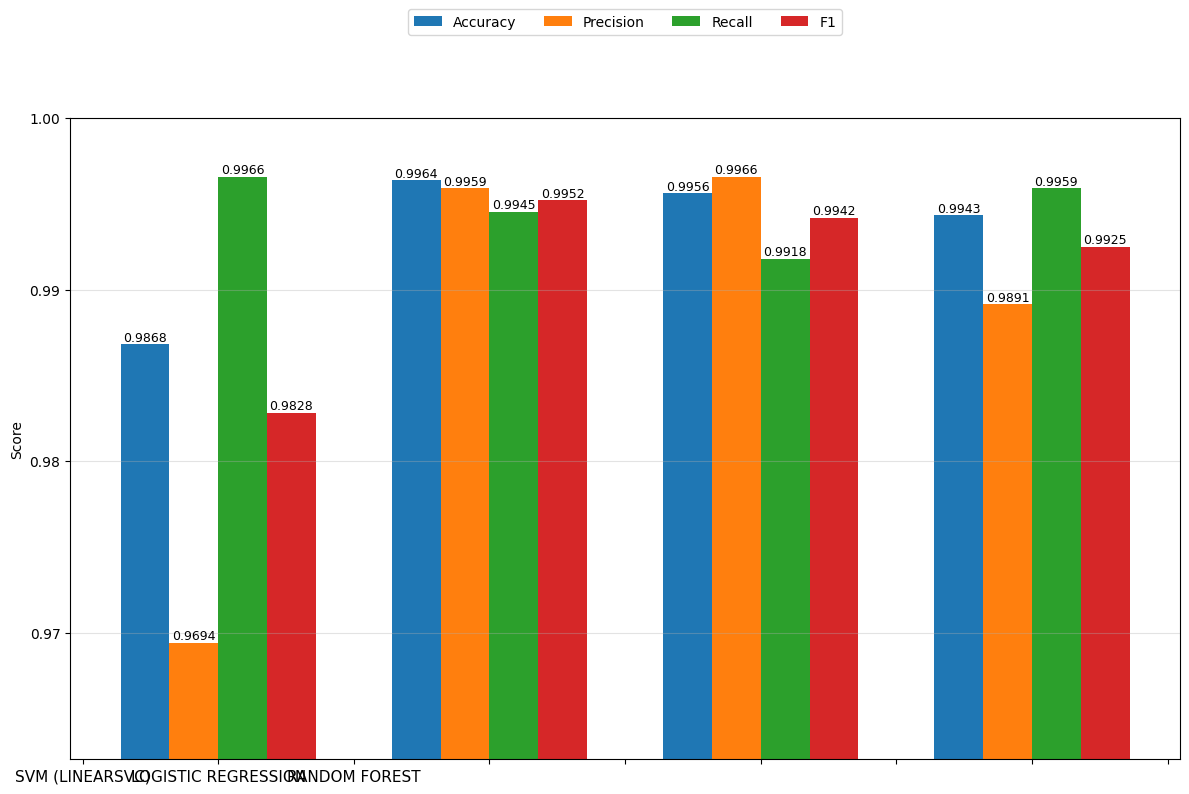

In [10]:
plot_df = metrics_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1"]]

min_score = float(plot_df.min().min())
max_score = float(plot_df.max().max())
pad = max(1e-4, (max_score - min_score) * 0.25)

ymin = max(0.0, min_score - pad)   # auto zoom
ymax = min(1.0, max_score + pad)

x = np.arange(len(plot_df.index))
w = 0.18
cols = list(plot_df.columns)

fig, ax = plt.subplots(figsize=(12, 8))
for i, col in enumerate(cols):
    vals = plot_df[col].values
    bars = ax.bar(x + (i - (len(cols)-1)/2) * w, vals, width=w, label=col)
    for b, v in zip(bars, vals):
        ax.text(b.get_x() + b.get_width()/2, v, f"{v:.4f}",
                ha="center", va="bottom", fontsize=9, rotation=0)

ax.set_yticks(np.arange(0.96, 1.00, 0.01))
ax.set_xticklabels([m.upper() for m in plot_df.index], fontsize=11)
ax.set_ylabel("Score")
ax.set_ylim(ymin, ymax)
ax.grid(axis="y", alpha=0.35)
ax.legend(loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.18))
fig.tight_layout()
plt.show()
